## Traffic Sign Recognition with Deep Learning

The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. Given an image of a traffic sign, our model should be able to tell it's type (*e.g. Stop sign, speed limit, yield sign*). We'll work with images that are properly cropped such that the traffic sign takes most of the image. So don't worry about edge cases as of now.

You are free to use either Keras or Pytorch.

Send the code to amritansh@learnbay.co

We will use the **Belgian Traffic Sign** Dataset because it is big enough to train on, and yet small enough to be easy to work with.

You can download the dataset from : https://btsd.ethz.ch/shareddata/

There are a lot of datasets on that page, but you only need the two files listed under BelgiumTS for Classification (cropped images):



1.   BelgiumTSC_Training (https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Training.zip)
2.   BelgiumTSC_Testing (https://btsd.ethz.ch/shareddata/BelgiumTSC/BelgiumTSC_Testing.zip)



The images in this dataset are in an old .ppm format. So old, in fact, that most tools don’t support it. Which meant that we cann’t casually browse the folders to take a look at the images. Luckily, the Scikit Image library recognizes this format. This code below will load the data and return two lists: images and labels.

In [3]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf


# Allow image embeding in notebook
%matplotlib inline

In [4]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


### Parse and load the dataset

In [5]:
def load_data(data_dir):
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir)
                   if os.path.isdir(os.path.join(data_dir, d))]
    print("data_dir", data_dir)
    print(directories)
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels # these provide you data in numpy arrays


   ** images** :  a list of images, each image is represted by a numpy array.
   
  **labels** :  a list of labels. Integers with values between 0 and 61.


In [6]:
# Load training and testing datasets.
ROOT_PATH = "My Drive/PreetiK-TrafficSign-Assignment" # your root path
train_data_dir = os.path.join(ROOT_PATH, "BelgiumTSC_Training/Training")
test_data_dir = os.path.join(ROOT_PATH, "BelgiumTSC_Testing/Testing")

images, labels = load_data(train_data_dir)

My Drive/PreetiK-TrafficSign-Assignment/BelgiumTSC_Training/Training
My Drive/PreetiK-TrafficSign-Assignment/BelgiumTSC_Testing/Testing

data_dir My Drive/PreetiK-TrafficSign-Assignment/BelgiumTSC_Training/Training
['00055', '00061', '00057', '00060', '00059', '00058', '00054', '00053', '00056', '00052', '00048', '00046', '00050', '00051', '00045', '00044', '00047', '00049', '00042', '00043', '00036', '00032', '00038', '00033', '00035', '00040', '00034', '00039', '00037', '00041', '00024', '00029', '00022', '00025', '00030', '00028', '00023', '00026', '00031', '00027', '00013', '00015', '00014', '00020', '00017', '00019', '00021', '00018', '00012', '00016', '00003', '00006', '00005', '00009', '00011', '00002', '00008', '00007', '00010', '00004', '00001', '00000']


### Explore the Dataset

How many images and labels does it have?

Display the first image of each label.

In [15]:
# your code here
# Number of images and labels
def display_images_and_labels(images,labels):
  num_images = len(images)
  num_labels = len(labels)

  print("Number of images:", num_images)
  print("Number of labels:", num_labels)

  # Display the first image of each label
  plt.figure(figsize=(5,5))
  unique_labels = set(labels)
  for label in unique_labels:
      index = labels.index(label)
      first_image_index = index
      print("Label:", label)
      plt.imshow(images[first_image_index])
      plt.axis('off')
      plt.show()






Number of images: 4575
Number of labels: 4575
Label: 0


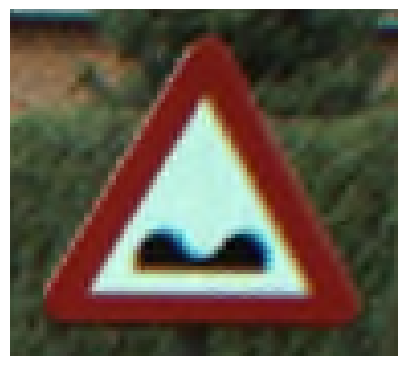

Label: 1


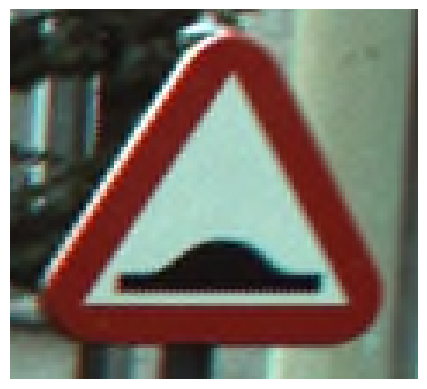

Label: 2


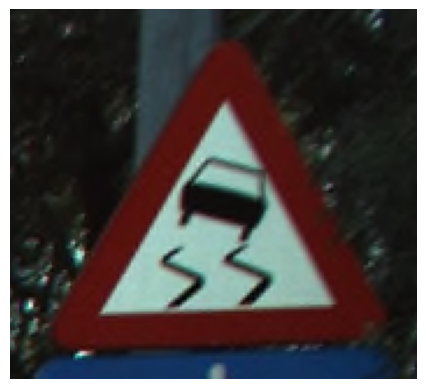

Label: 3


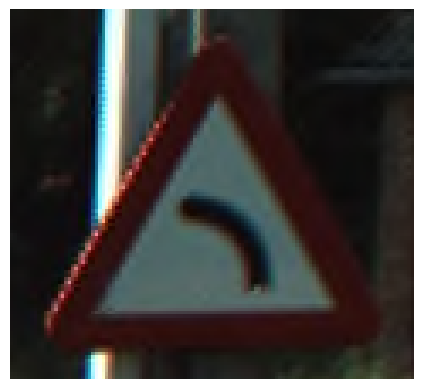

Label: 4


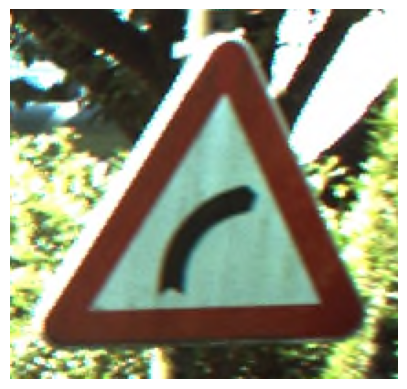

Label: 5


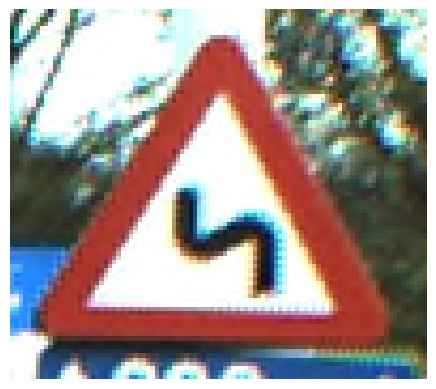

Label: 6


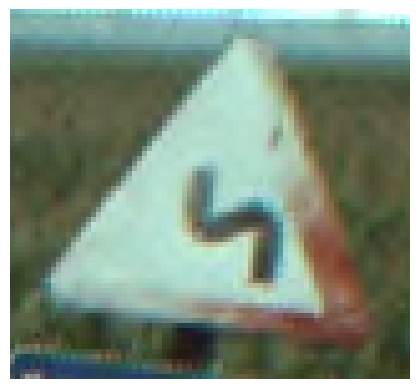

Label: 7


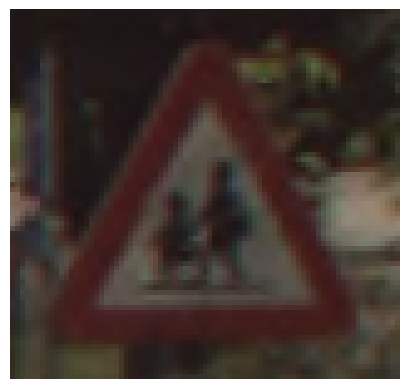

Label: 8


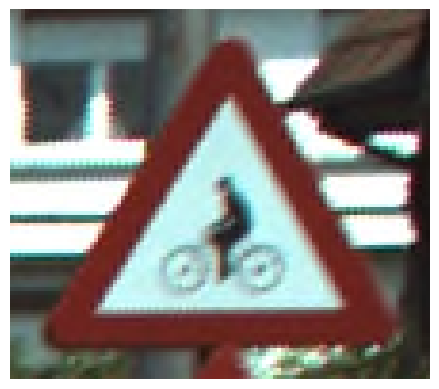

Label: 9


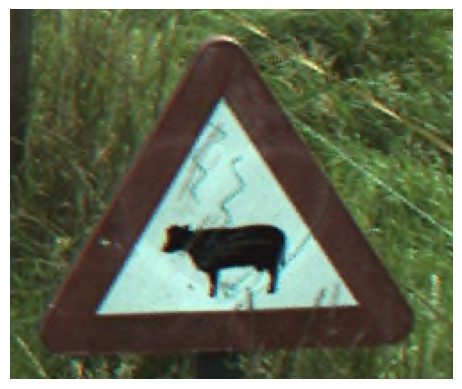

Label: 10


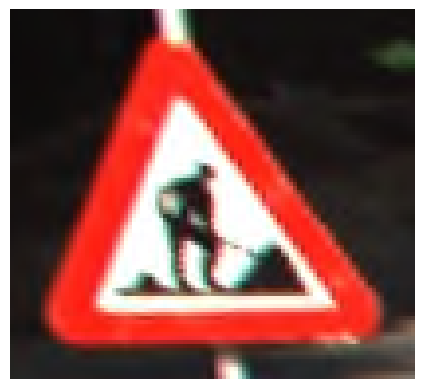

Label: 11


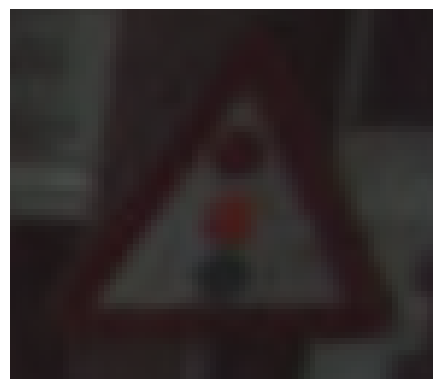

Label: 12


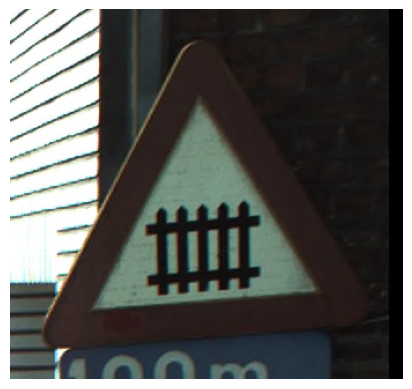

Label: 13


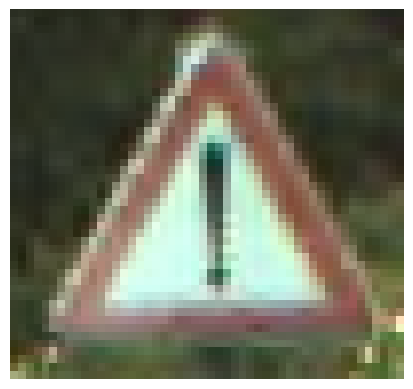

Label: 14


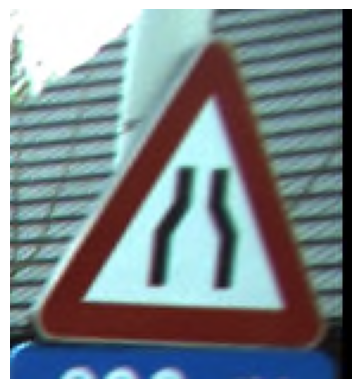

Label: 15


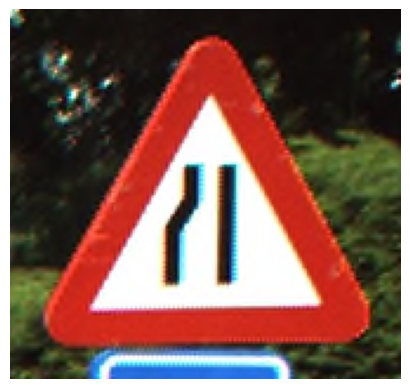

Label: 16


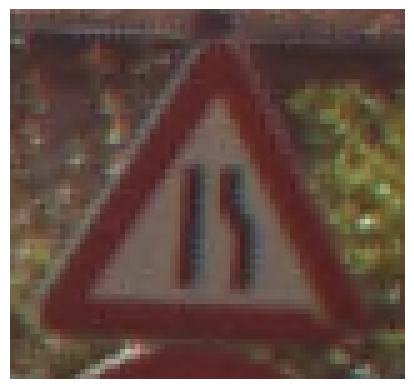

Label: 17


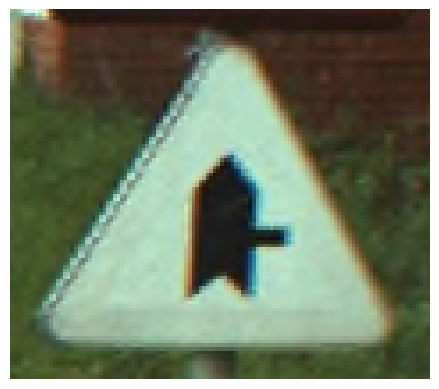

Label: 18


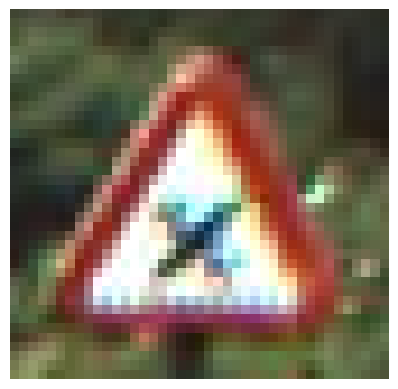

Label: 19


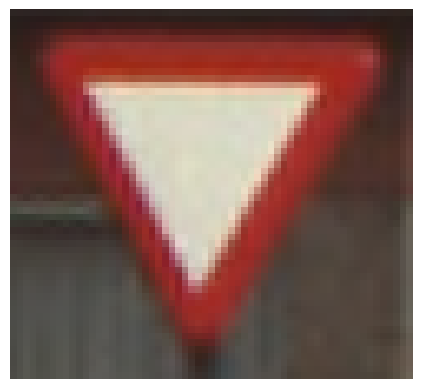

Label: 20


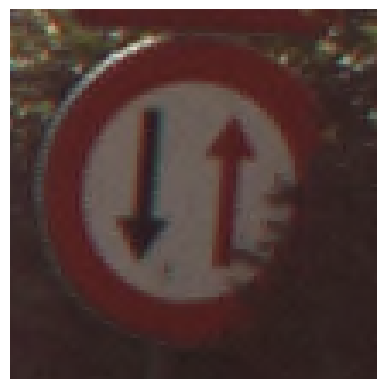

Label: 21


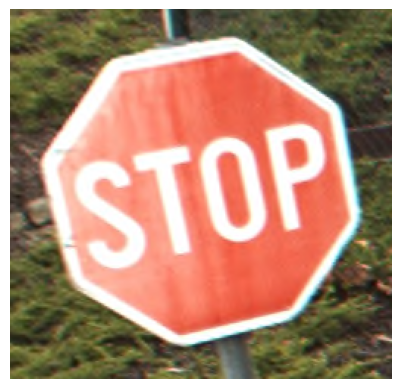

Label: 22


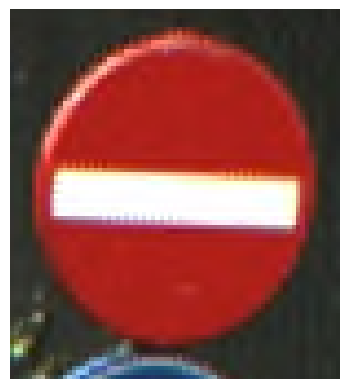

Label: 23


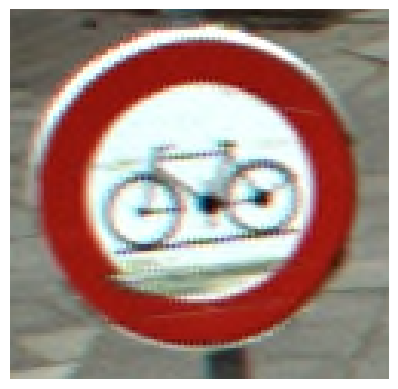

Label: 24


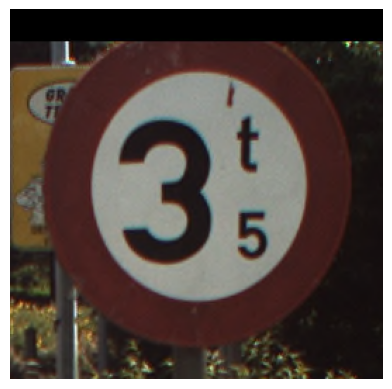

Label: 25


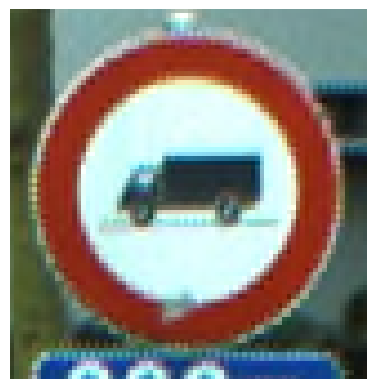

Label: 26


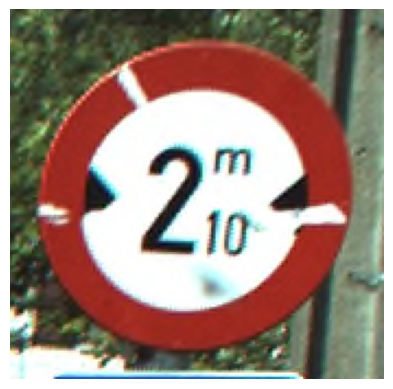

Label: 27


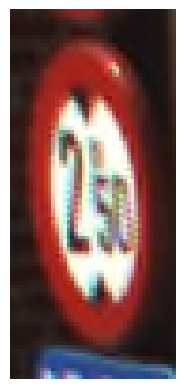

Label: 28


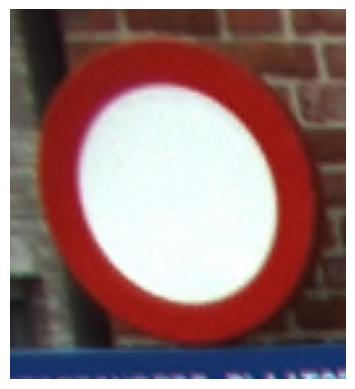

Label: 29


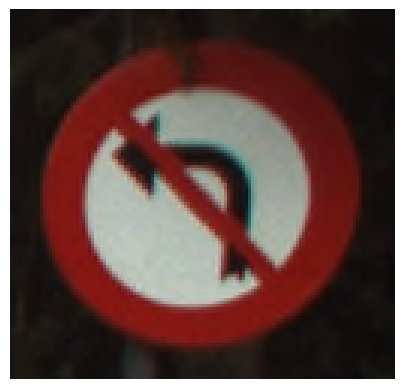

Label: 30


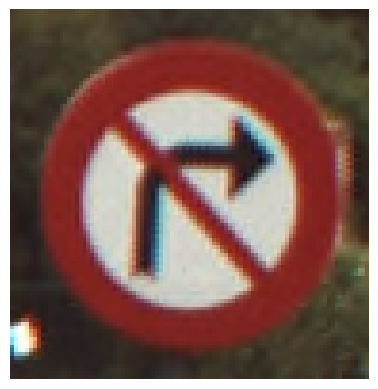

Label: 31


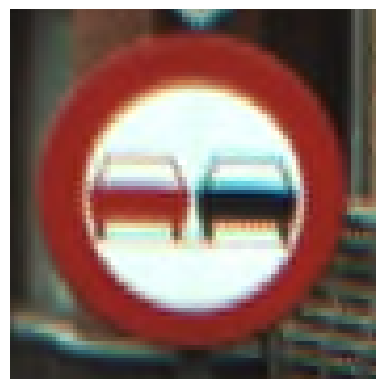

Label: 32


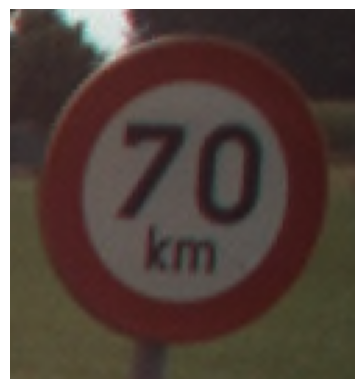

Label: 33


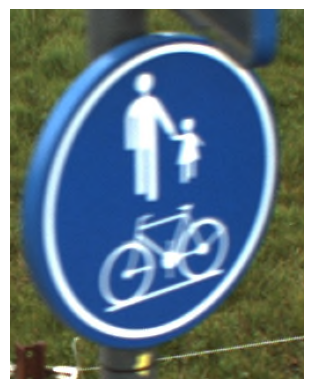

Label: 34


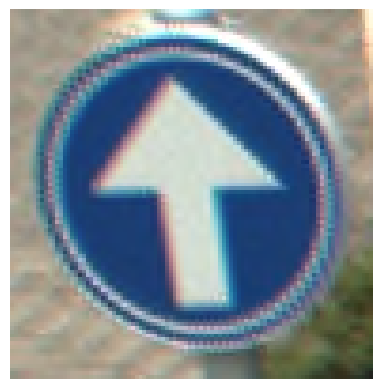

Label: 35


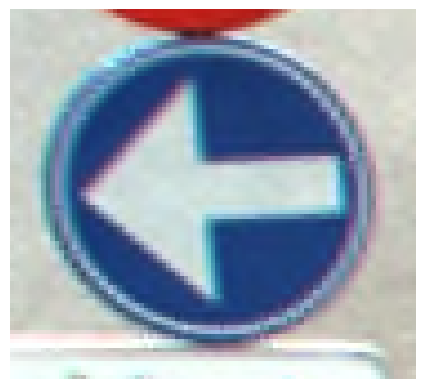

Label: 36


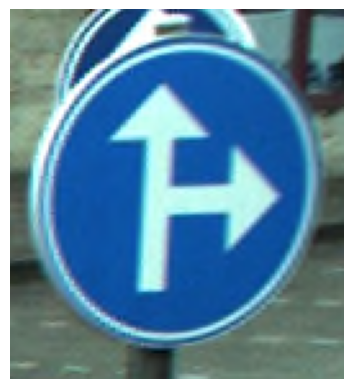

Label: 37


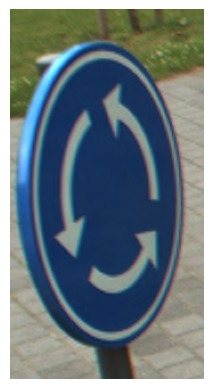

Label: 38


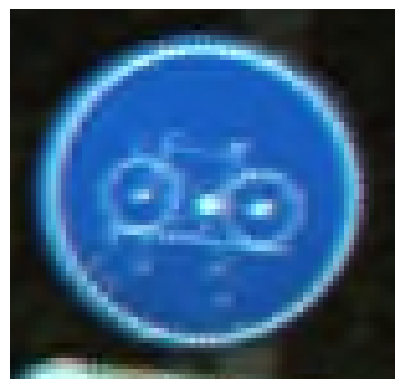

Label: 39


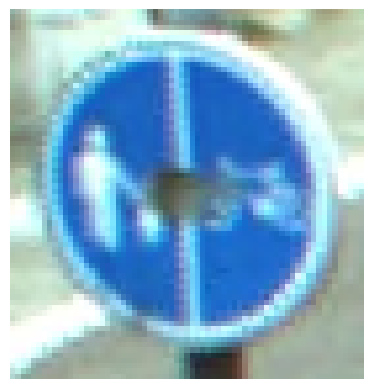

Label: 40


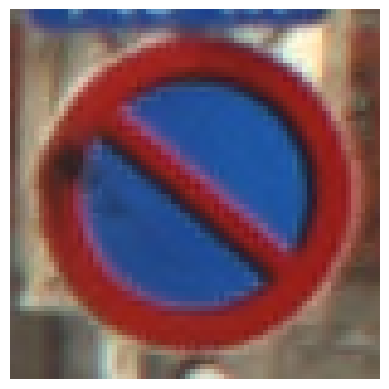

Label: 41


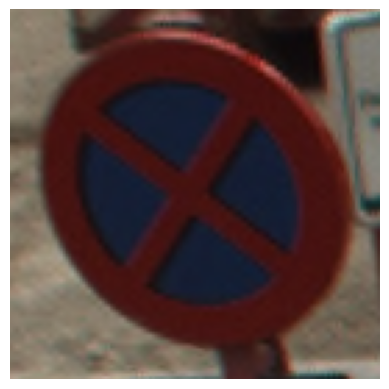

Label: 42


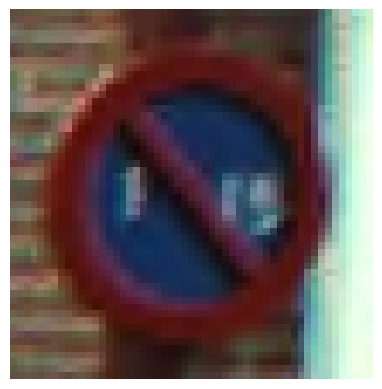

Label: 43


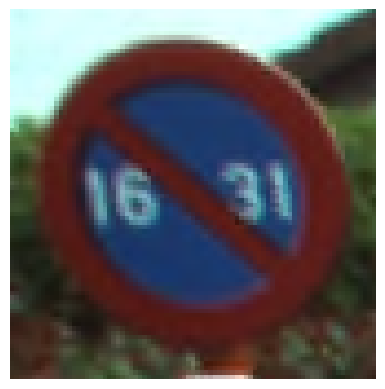

Label: 44


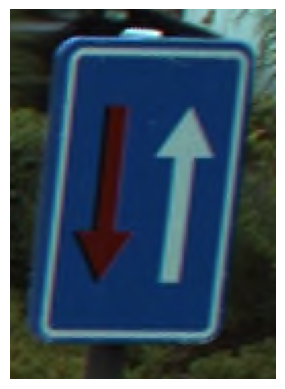

Label: 45


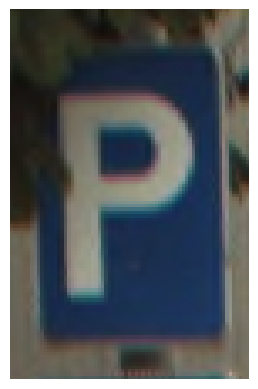

Label: 46


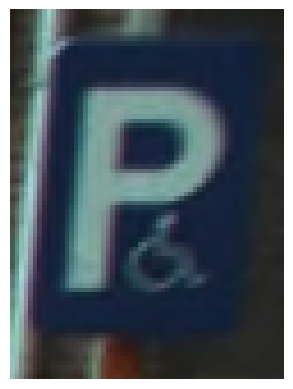

Label: 47


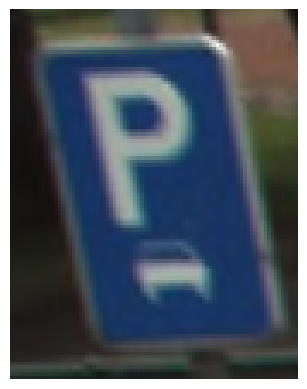

Label: 48


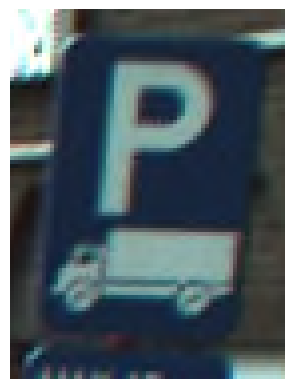

Label: 49


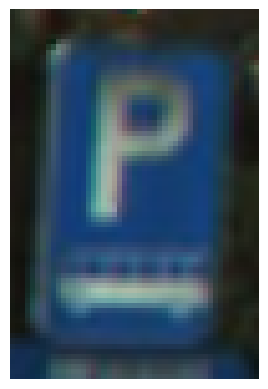

Label: 50


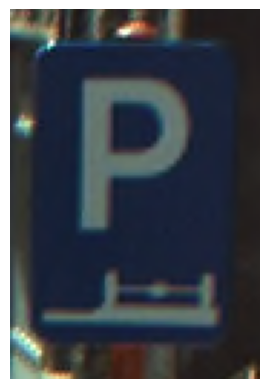

Label: 51


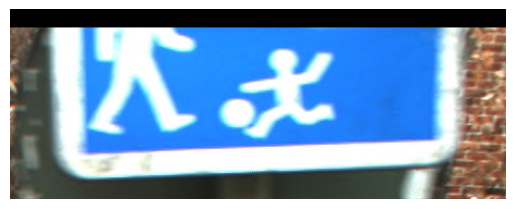

Label: 52


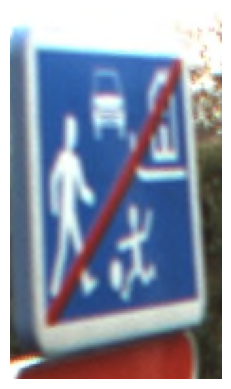

Label: 53


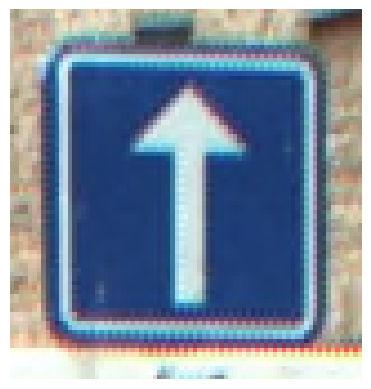

Label: 54


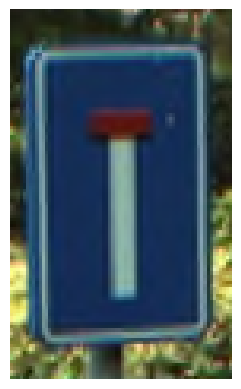

Label: 55


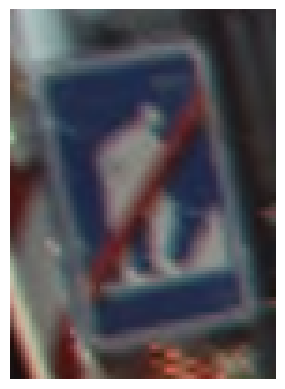

Label: 56


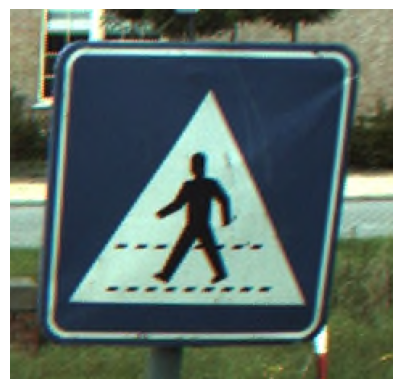

Label: 57


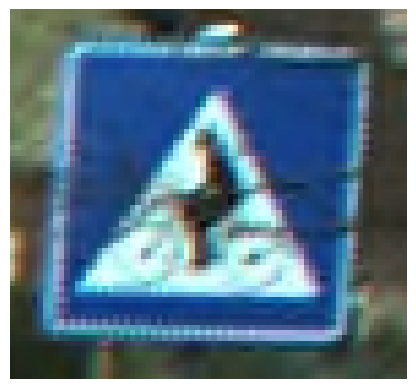

Label: 58


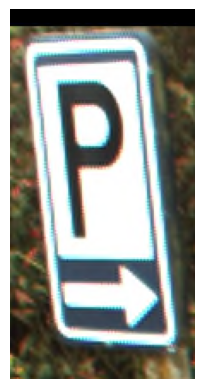

Label: 59


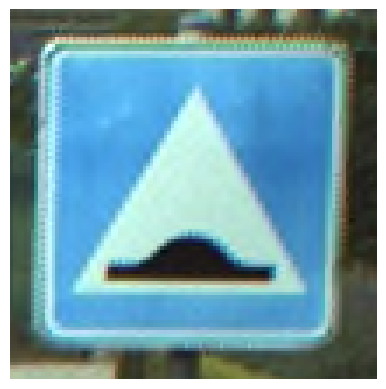

Label: 60


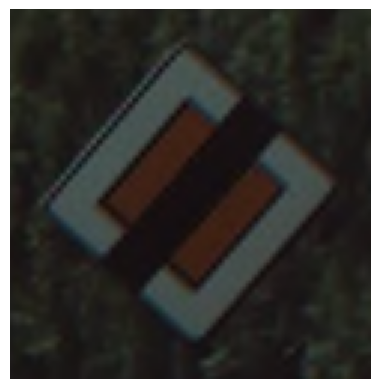

Label: 61


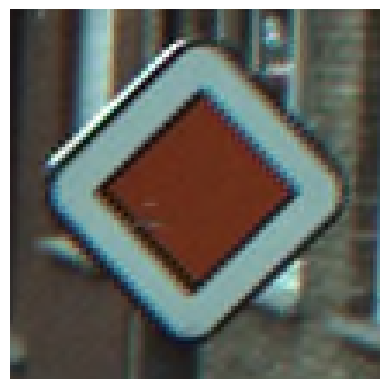

In [16]:
display_images_and_labels(images,labels)

### Handling images of different sizes

Ideally neural networks expect a fixed-size input. But these images are not all the same size. A common approach is to crop and pad the images to a selected apect ratio, but then we have to make sure that we don't cut-off parts of the traffic signs in the process. That seems like it might require manual work!

We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well.

And while we're at it, let's make the images smaller. The larger the input data, the larger the model, and the slower it is to train. In the early stages of development we want fast training to avoid long waits between iterations while we change the code rapidly.

Number of images: 4575
Number of labels: 4575
Label: 0


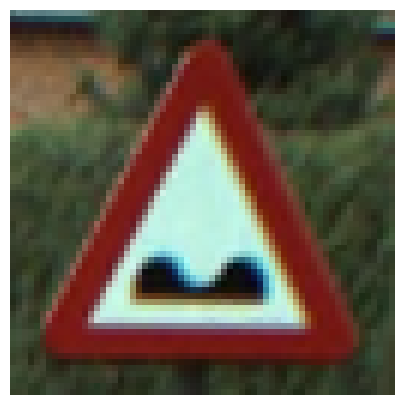

Label: 1


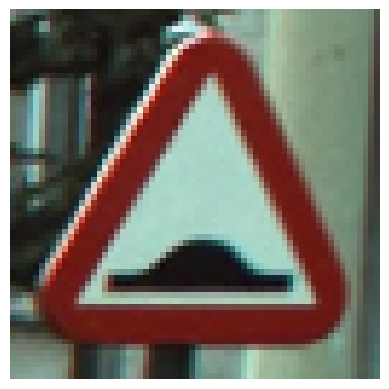

Label: 2


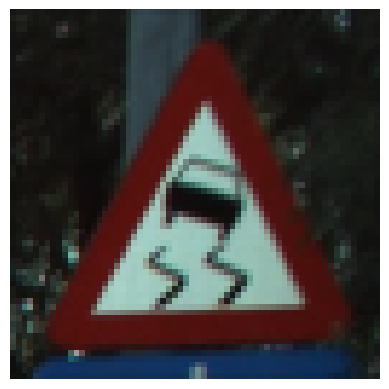

Label: 3


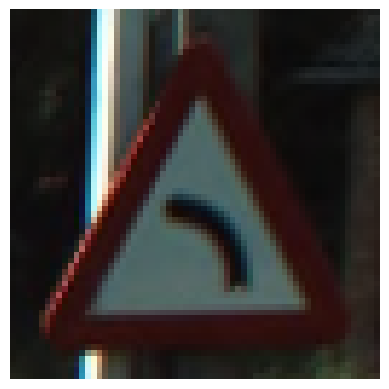

Label: 4


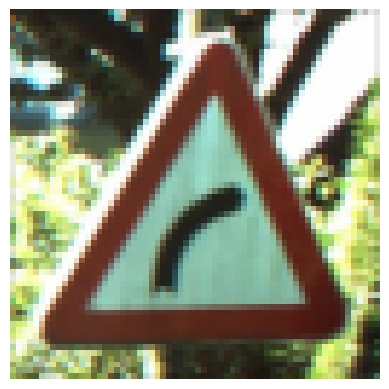

Label: 5


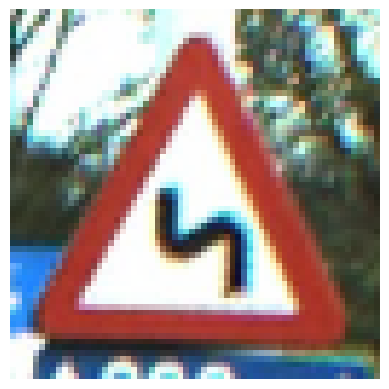

Label: 6


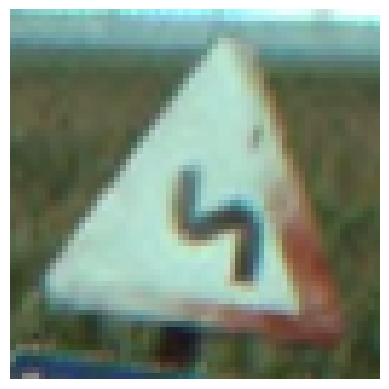

Label: 7


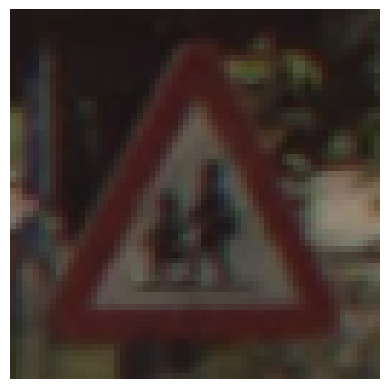

Label: 8


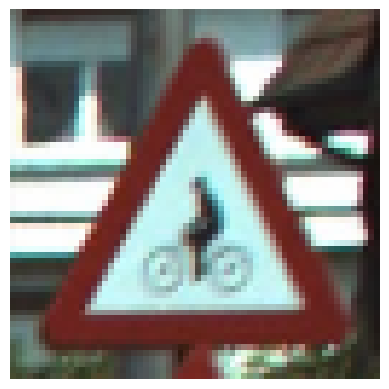

Label: 9


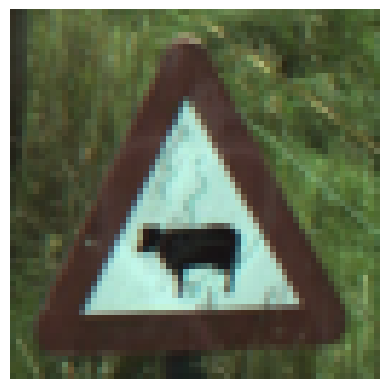

Label: 10


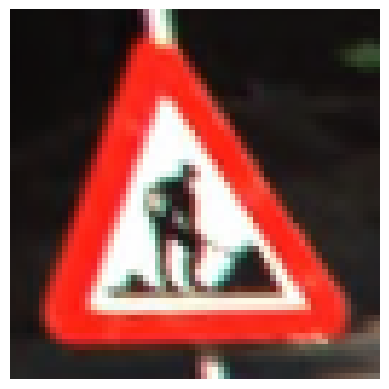

Label: 11


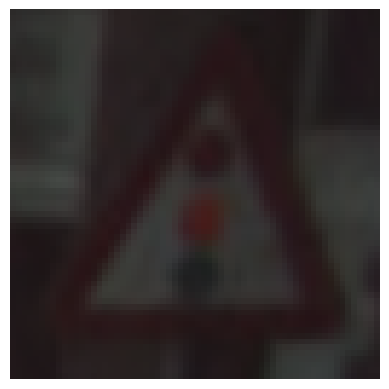

Label: 12


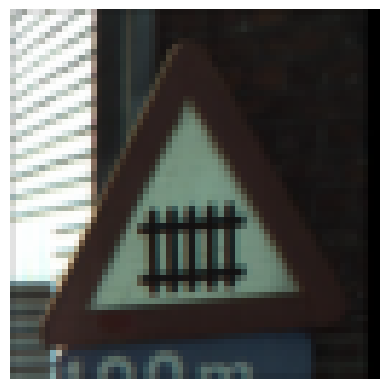

Label: 13


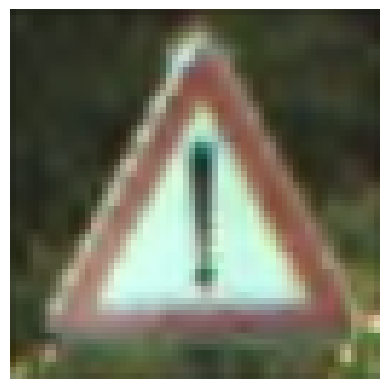

Label: 14


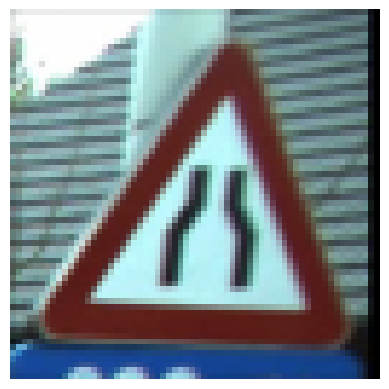

Label: 15


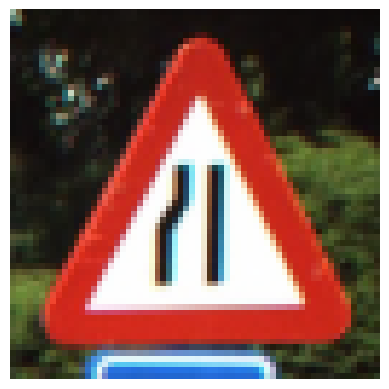

Label: 16


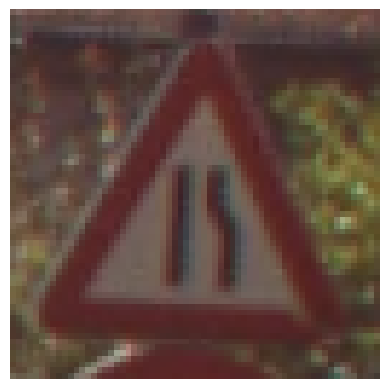

Label: 17


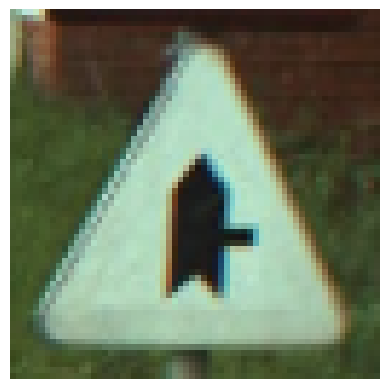

Label: 18


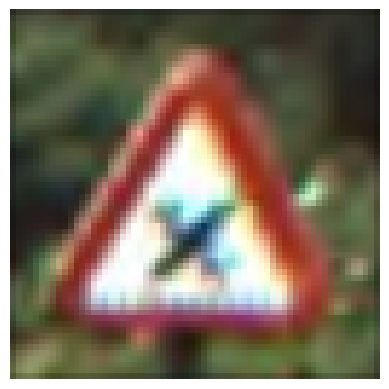

Label: 19


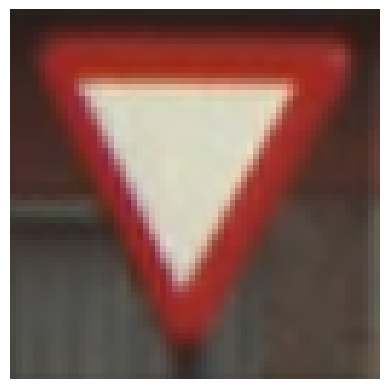

Label: 20


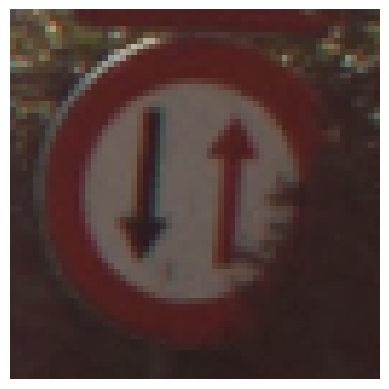

Label: 21


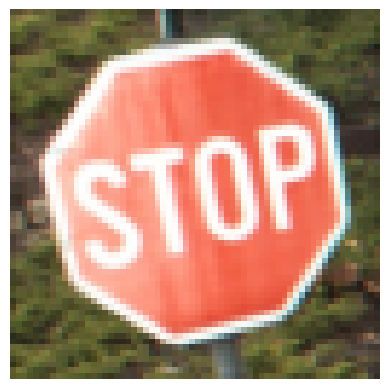

Label: 22


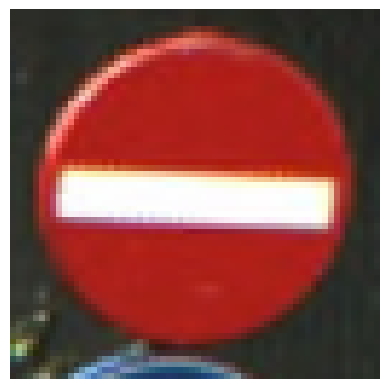

Label: 23


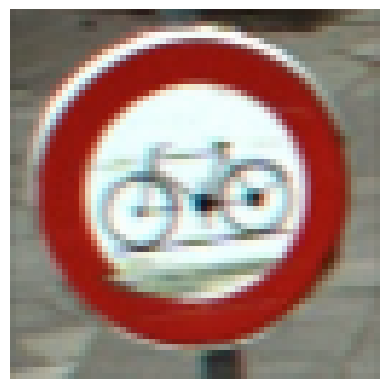

Label: 24


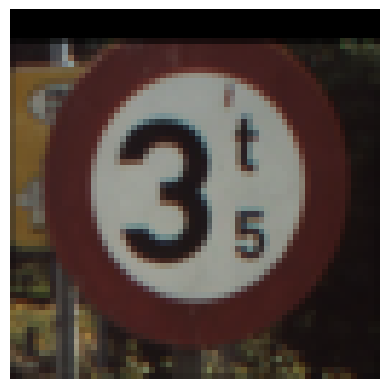

Label: 25


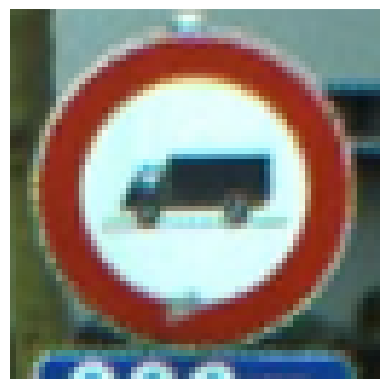

Label: 26


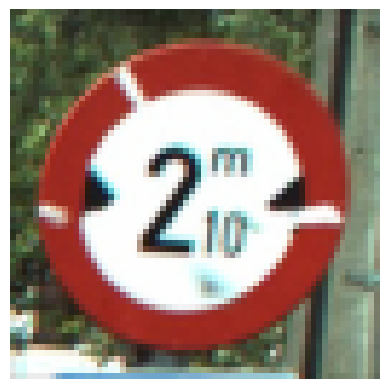

Label: 27


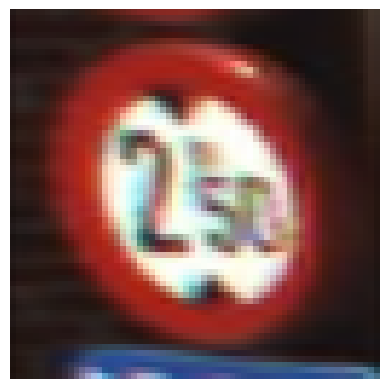

Label: 28


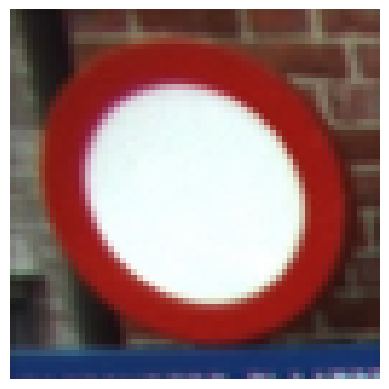

Label: 29


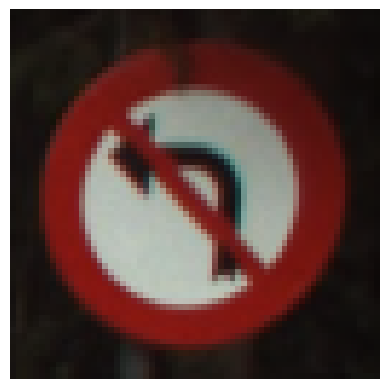

Label: 30


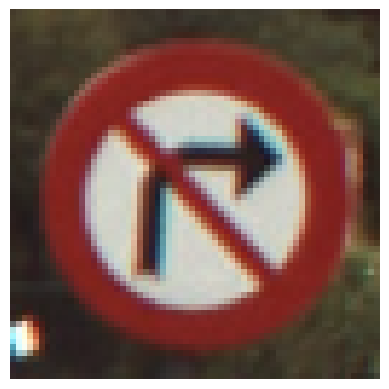

Label: 31


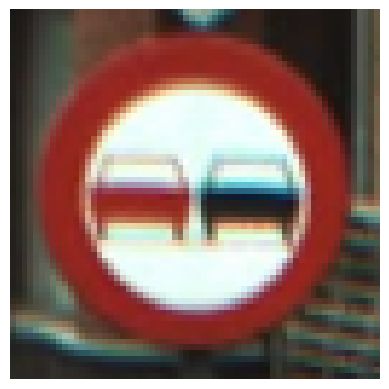

Label: 32


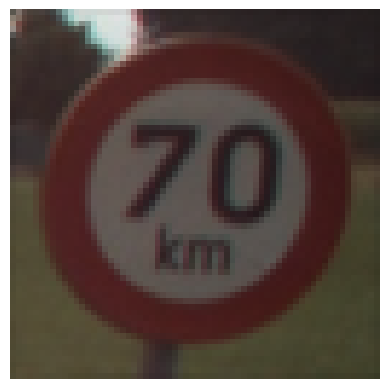

Label: 33


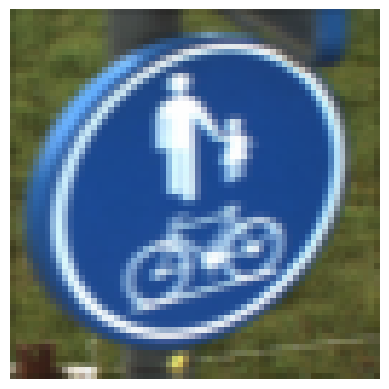

Label: 34


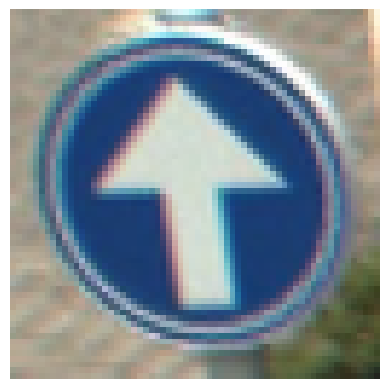

Label: 35


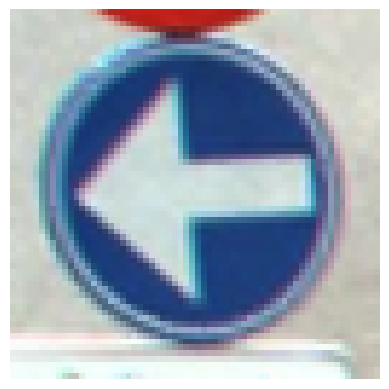

Label: 36


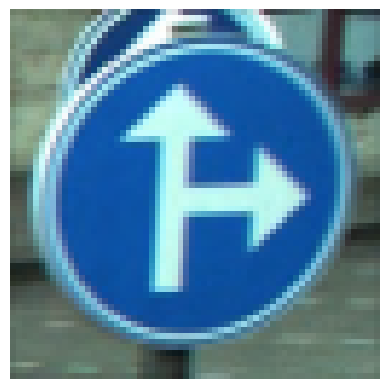

Label: 37


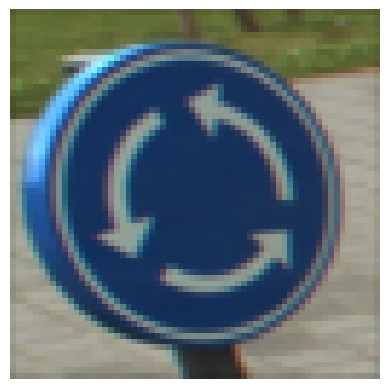

Label: 38


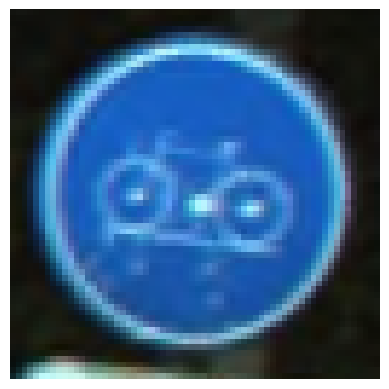

Label: 39


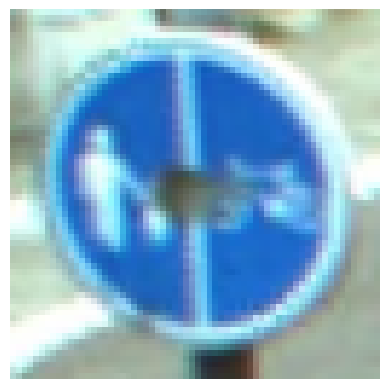

Label: 40


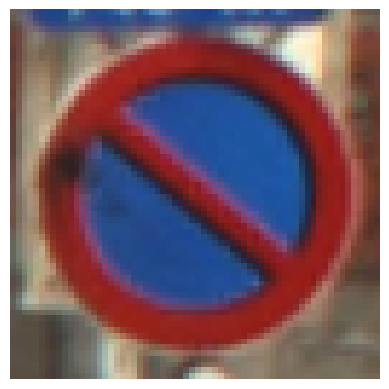

Label: 41


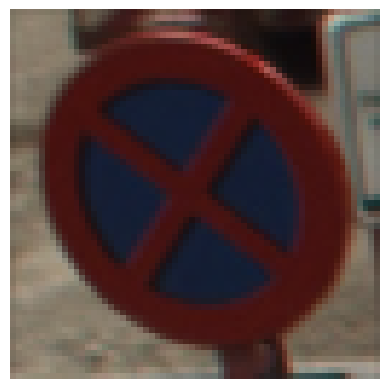

Label: 42


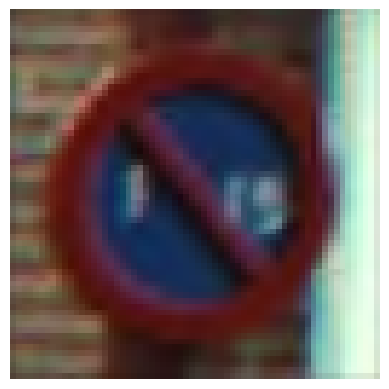

Label: 43


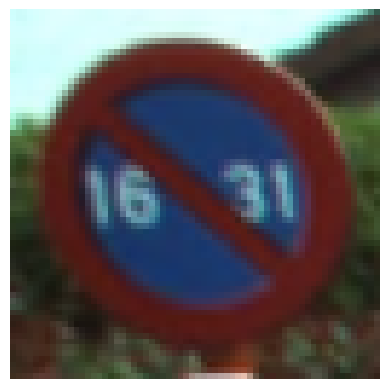

Label: 44


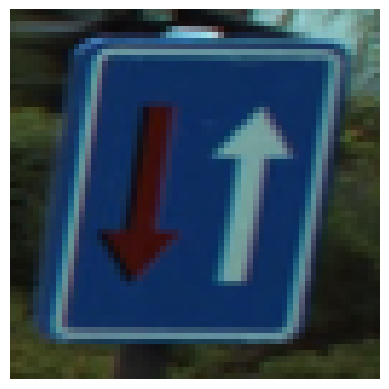

Label: 45


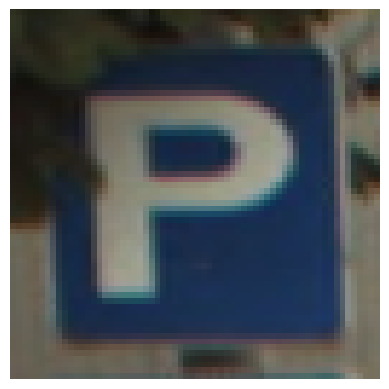

Label: 46


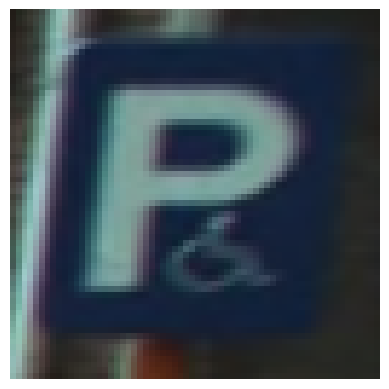

Label: 47


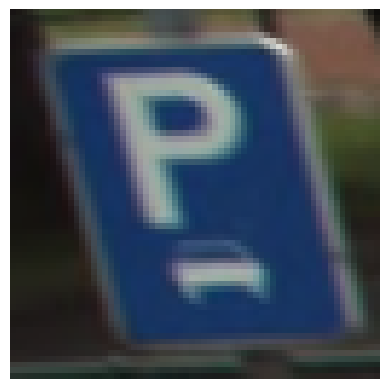

Label: 48


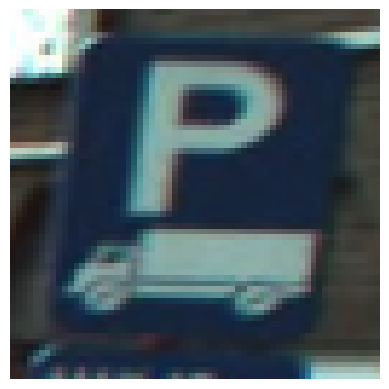

Label: 49


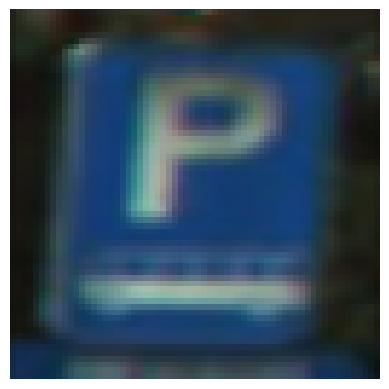

Label: 50


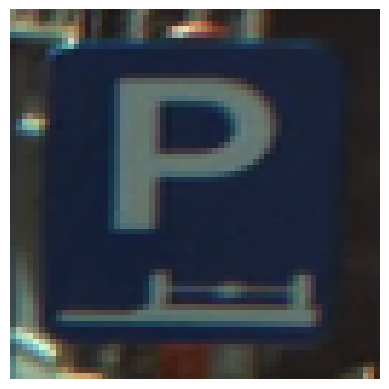

Label: 51


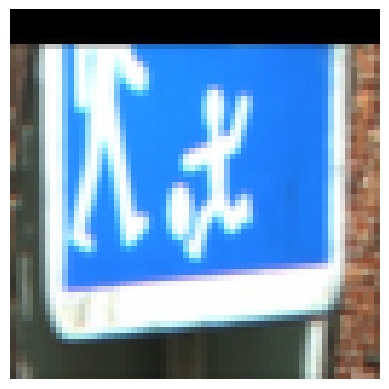

Label: 52


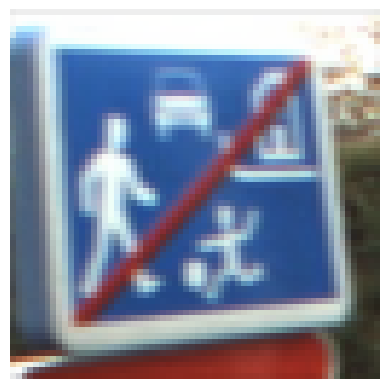

Label: 53


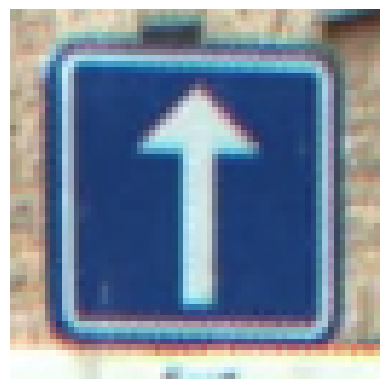

Label: 54


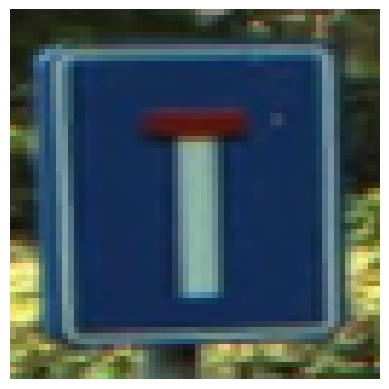

Label: 55


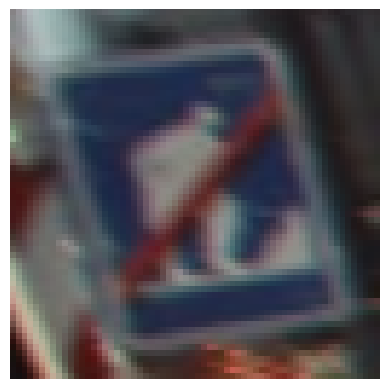

Label: 56


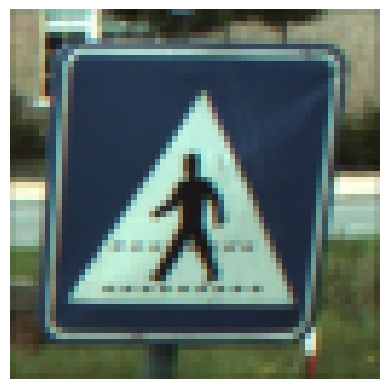

Label: 57


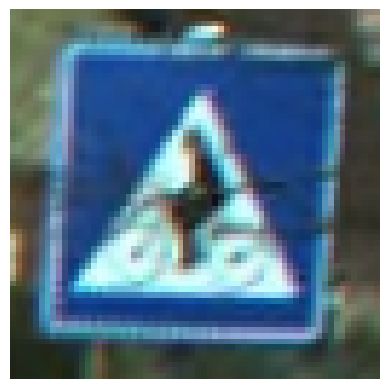

Label: 58


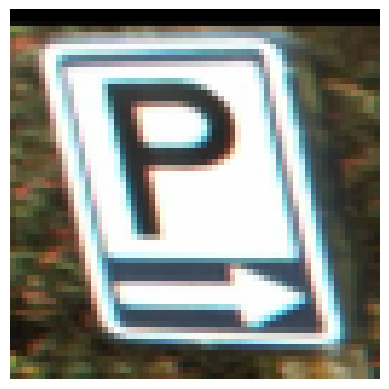

Label: 59


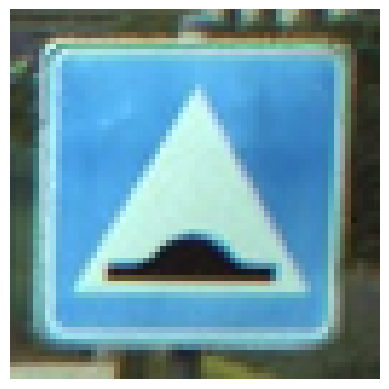

Label: 60


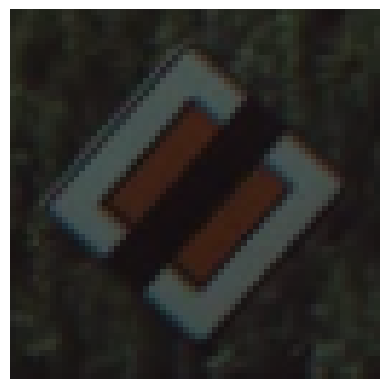

Label: 61


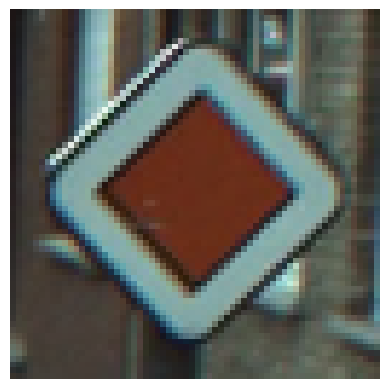

In [17]:
# Resize images
images64 = [skimage.transform.resize(image, (64, 64), mode='constant')
                for image in images]
display_images_and_labels(images64, labels)

### Create a Model

In [18]:
images_np = np.array(labels)
print("Shape of the numpy array:", images_np.shape)

Shape of the numpy array: (4575,)


In [19]:
# your code here.
# One could design from scratch or use some standard ConvNets provided in Keras and train it from scratch
# Load the  train data and test data
x_train=np.stack(images64)
y_train= np.array(labels)


print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)

from numpy import asarray, unique, argmax
import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization

# n_classes = len(unique(y_train))
# reshape data to have a single channel
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 3))

# determine the shape of the input images
in_shape = x_train.shape[1:]
# determine the number of classes
n_classes = len(unique(y_train))
print(in_shape, n_classes)
# normalize pixel values
x_train = x_train.astype('float32') / 255.0


x_train shape: (4575, 64, 64, 3) y_train shape: (4575,)
(64, 64, 3) 62


In [20]:
# Define CNN Model
model = Sequential()
model.add(Conv2D(64, (5,5), padding='same',activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(Conv2D(64, (5,5), padding='same',activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2))) # you could add more no of Conv2d and max pooling layers for better performance
model.add(Conv2D(256, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(256, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2))) # you could add more no of Conv2d and max pooling layers for better performance
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.20))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.20))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.20))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.20))
model.add(Dense(n_classes, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       4

### Training

In [21]:
# your code here
from sklearn.model_selection import train_test_split
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit the model

# Now we split the dataset into training and validation sets with stratified sampling
x_train, x_test, y_train, y_test = train_test_split(np.stack(images64), np.array(labels), test_size=0.2, stratify=labels)

# Then you can use model.fit() with the generated training and validation data
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=25, batch_size=32, verbose=1, callbacks=keras.callbacks.Callback())

# history = model.fit(x_train, y_train, validation_split=0.2, epochs=25, batch_size=32, verbose=1, callbacks=keras.callbacks.Callback())

Epoch 1/25
115/115 [==============================] - 14s 39ms/step - loss: 4.0029 - accuracy: 0.1205 - val_loss: 3.3544 - val_accuracy: 0.1934
Epoch 2/25
115/115 [==============================] - 3s 23ms/step - loss: 2.7097 - accuracy: 0.3303 - val_loss: 2.4249 - val_accuracy: 0.4284
Epoch 3/25
115/115 [==============================] - 3s 23ms/step - loss: 1.8544 - accuracy: 0.5197 - val_loss: 2.1519 - val_accuracy: 0.5049
Epoch 4/25
115/115 [==============================] - 3s 23ms/step - loss: 1.3086 - accuracy: 0.6454 - val_loss: 0.8907 - val_accuracy: 0.7585
Epoch 5/25
115/115 [==============================] - 3s 23ms/step - loss: 0.9465 - accuracy: 0.7374 - val_loss: 0.6216 - val_accuracy: 0.8087
Epoch 6/25
115/115 [==============================] - 3s 23ms/step - loss: 0.7642 - accuracy: 0.7705 - val_loss: 0.4843 - val_accuracy: 0.8645
Epoch 7/25
115/115 [==============================] - 3s 23ms/step - loss: 0.6827 - accuracy: 0.8027 - val_loss: 0.4759 - val_accuracy: 0.859

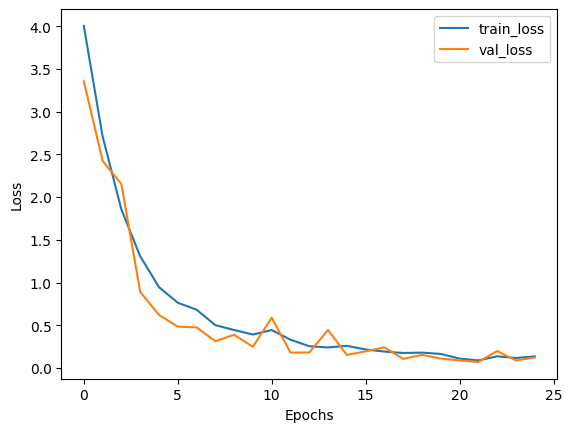

In [22]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])

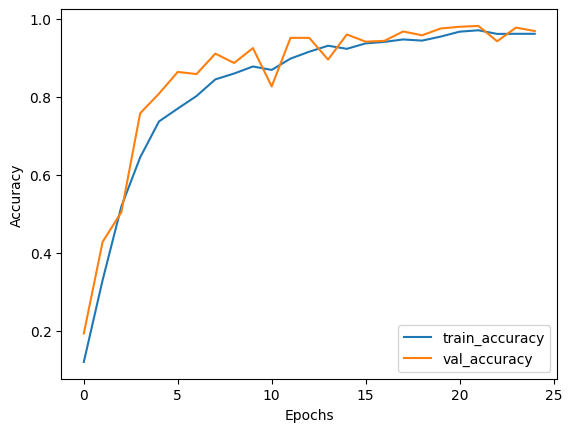

In [23]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

In [42]:
from sklearn.metrics import classification_report
radx = np.random.randint(0, len(x_test)-20)
img = x_test[radx:radx]
# prediction
# predict = model.predict(np.expand_dims(img, axis=0))
predict = model.predict(x_test)
pred= np.argmax(predict,axis=1)
# predicted_label = np.array([np.argmax(predict)])
# Generate the classification report
report = classification_report(y_test, pred)
# Print the classification report
print(report)

29/29 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      1.00      1.00        22
           2       1.00      0.33      0.50         3
           3       0.60      1.00      0.75         3
           4       0.75      1.00      0.86         3
           5       0.50      0.50      0.50         2
           6       1.00      1.00      1.00         4
           7       0.94      1.00      0.97        31
           8       0.71      1.00      0.83         5
           9       0.67      1.00      0.80         4
          10       1.00      0.75      0.86         4
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         4
          13       1.00      0.89      0.94        18
          14       1.00      0.89      0.94         9
          15       1.00      1.00      1.00         2
          16       0.67     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
## After  Image Augmentation

#first code with your own ConvNet design
# Later  you can try standard models and compare the results

from keras.preprocessing.image import ImageDataGenerator

# Preprocessing and Image augmentation
datagen = ImageDataGenerator(
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=False,  # randomly flip images
    vertical_flip=False, # randomly flip images
    # Randomly zoom into images by a factor of 0.2
    zoom_range=0.2,
    # Randomly scale images by a factor of 0.2
    shear_range=0.2,
    # Use 'nearest' fill mode for newly created pixels
    fill_mode='nearest'

    )




In [44]:
datagen.fit(x_train)
x_train[:1].shape
datagen.fit(x_train[:1])
samples = datagen.flow(x_train[:1])

In [45]:
# Define CNN Model
model = Sequential()
model.add(Conv2D(64, (5,5), padding='same',activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(Conv2D(64, (5,5), padding='same',activation='relu', kernel_initializer='he_uniform', input_shape=in_shape))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(128, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(128, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2))) # you could add more no of Conv2d and max pooling layers for better performance
model.add(Conv2D(256, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(256, (5,5), padding ='same', activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2))) # you could add more no of Conv2d and max pooling layers for better performance
# model.add(Conv2D(256, (3,3), padding ='same', activation='relu', kernel_initializer='he_uniform'))
# model.add(Conv2D(256, (3,3), padding ='same', activation='relu', kernel_initializer='he_uniform'))
# model.add(BatchNormalization())
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.30))
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.30))
model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.30))
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.30))
model.add(Dense(n_classes, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 64)        4864      
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 batch_normalization_3 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 128)       204928    
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)      

In [46]:
# define loss and optimizer
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# fit the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32),
                             validation_data=(x_test, y_test), use_multiprocessing=True,
                     steps_per_epoch=len(x_train) / 32, epochs=25)

Epoch 1/25


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


114/114 [==============================] - 10s 49ms/step - loss: 4.3901 - accuracy: 0.0973 - val_loss: 3.5209 - val_accuracy: 0.1880
Epoch 2/25
114/114 [==============================] - 6s 50ms/step - loss: 3.2682 - accuracy: 0.1945 - val_loss: 2.7381 - val_accuracy: 0.3005
Epoch 3/25
114/114 [==============================] - 6s 55ms/step - loss: 2.6462 - accuracy: 0.3221 - val_loss: 2.1840 - val_accuracy: 0.4546
Epoch 4/25
114/114 [==============================] - 5s 47ms/step - loss: 2.1818 - accuracy: 0.4208 - val_loss: 1.5615 - val_accuracy: 0.5617
Epoch 5/25
114/114 [==============================] - 6s 50ms/step - loss: 1.7448 - accuracy: 0.5109 - val_loss: 1.2925 - val_accuracy: 0.6273
Epoch 6/25
114/114 [==============================] - 5s 45ms/step - loss: 1.5283 - accuracy: 0.5577 - val_loss: 1.2431 - val_accuracy: 0.6153
Epoch 7/25
114/114 [==============================] - 6s 52ms/step - loss: 1.3418 - accuracy: 0.6082 - val_loss: 1.2842 - val_accuracy: 0.6372
Epoch 8/2

data_dir My Drive/PreetiK-TrafficSign-Assignment/BelgiumTSC_Testing/Testing
['00056', '00055', '00059', '00057', '00061', '00060', '00053', '00052', '00054', '00058', '00047', '00050', '00046', '00044', '00051', '00045', '00049', '00043', '00042', '00048', '00034', '00032', '00038', '00036', '00037', '00039', '00040', '00035', '00033', '00041', '00031', '00027', '00028', '00025', '00029', '00030', '00022', '00023', '00024', '00026', '00017', '00020', '00021', '00014', '00013', '00018', '00016', '00015', '00019', '00012', '00011', '00004', '00008', '00006', '00002', '00009', '00003', '00007', '00005', '00010', '00001', '00000']
Number of images: 2520
Number of labels: 2520
Label: 0


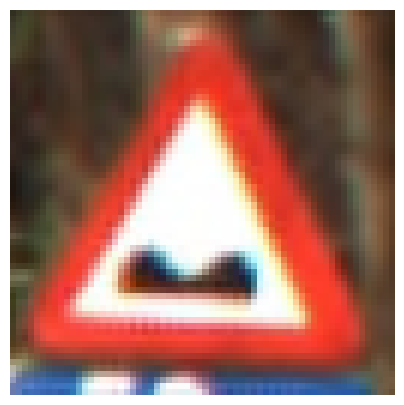

Label: 1


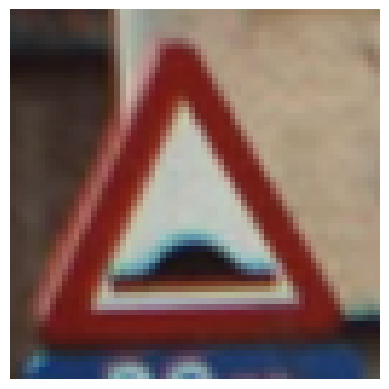

Label: 2


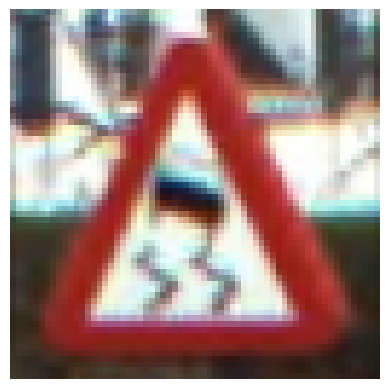

Label: 3


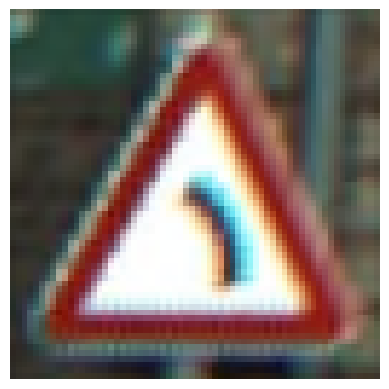

Label: 4


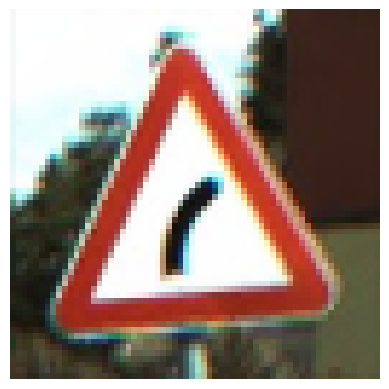

Label: 5


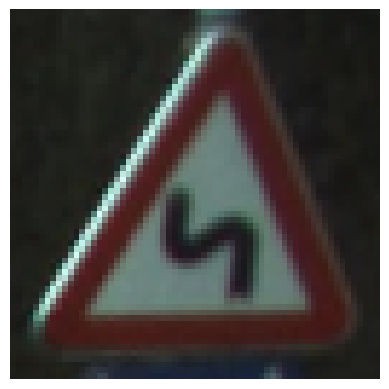

Label: 6


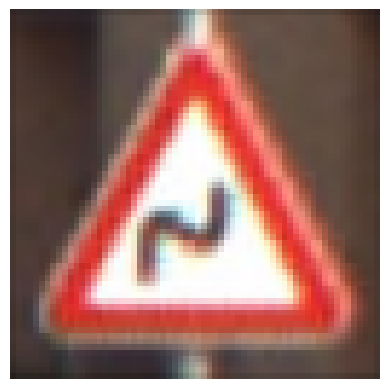

Label: 7


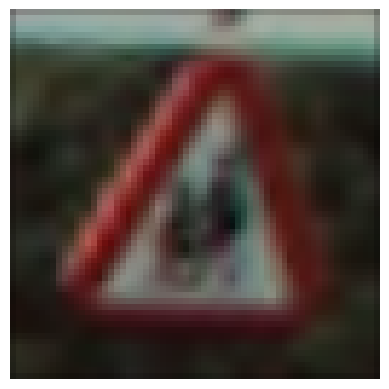

Label: 8


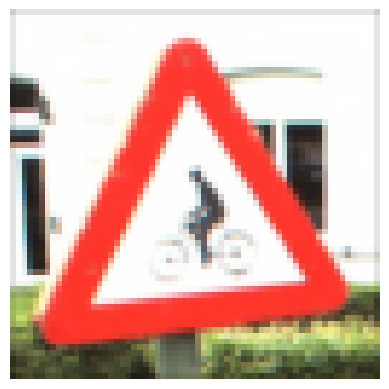

Label: 10


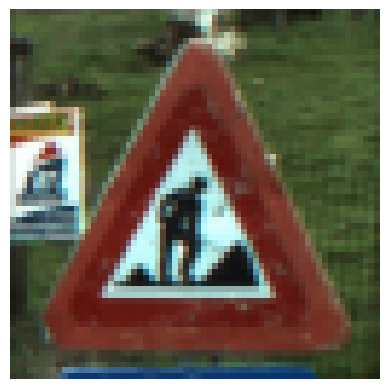

Label: 12


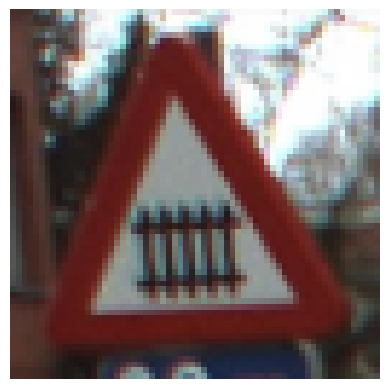

Label: 13


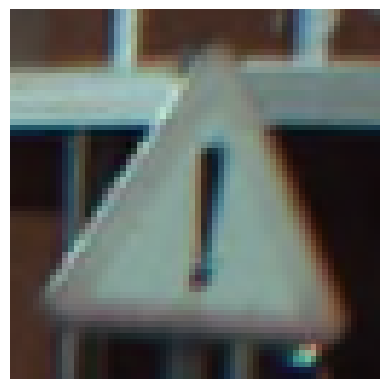

Label: 14


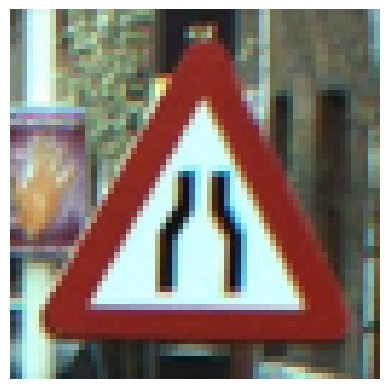

Label: 16


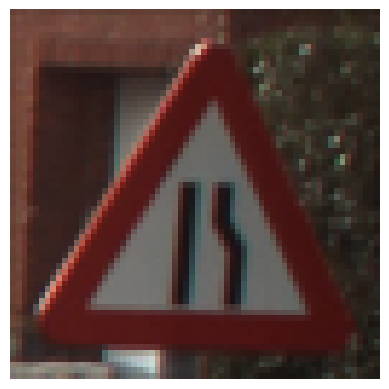

Label: 17


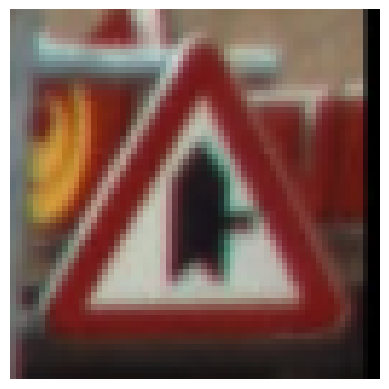

Label: 18


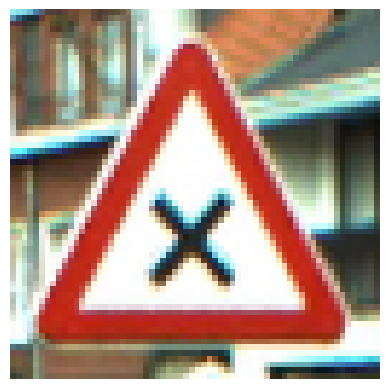

Label: 19


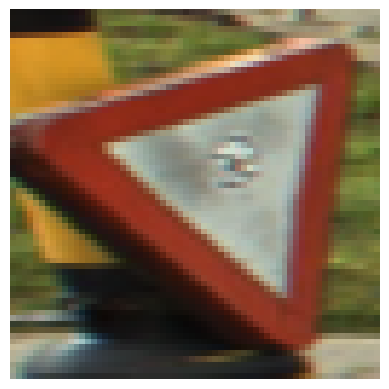

Label: 20


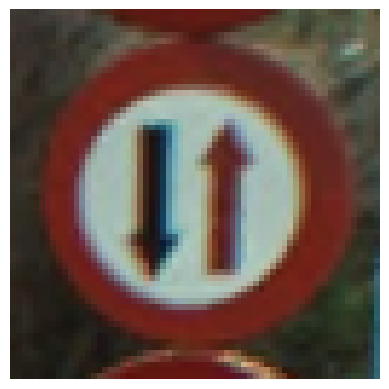

Label: 21


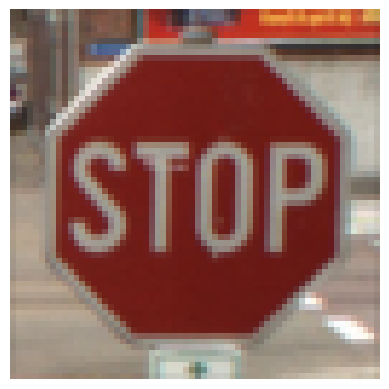

Label: 22


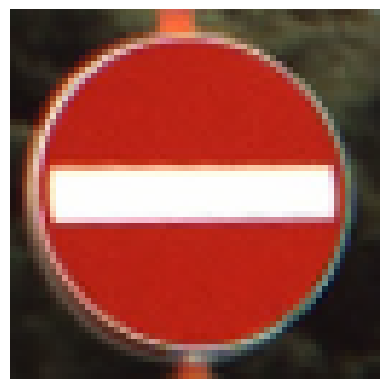

Label: 23


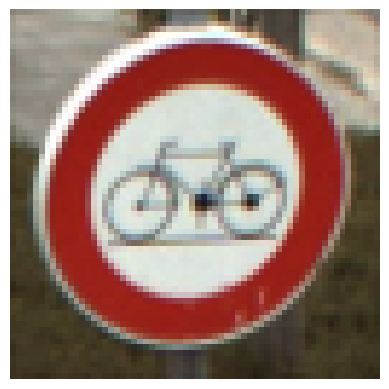

Label: 24


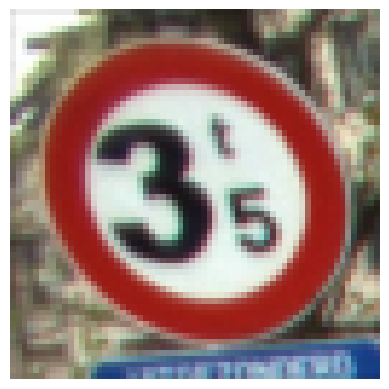

Label: 25


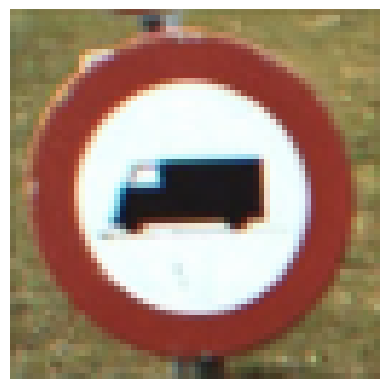

Label: 27


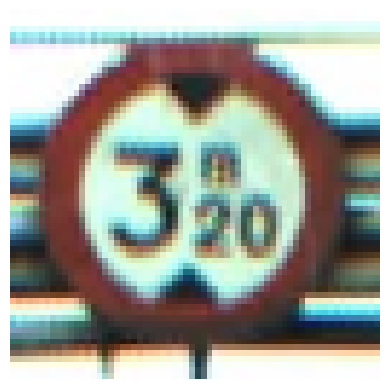

Label: 28


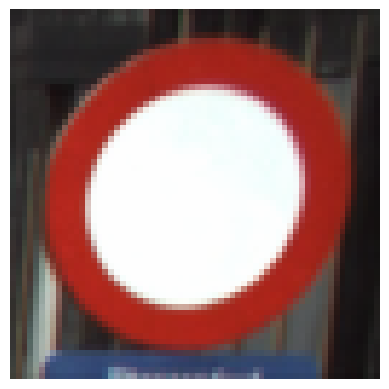

Label: 29


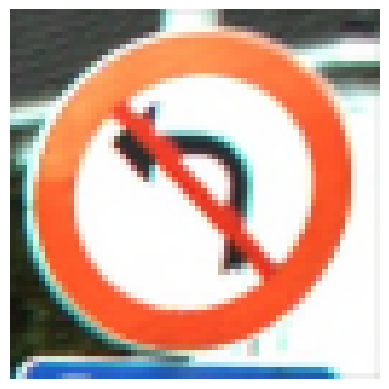

Label: 30


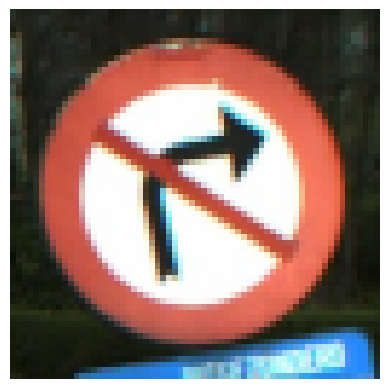

Label: 31


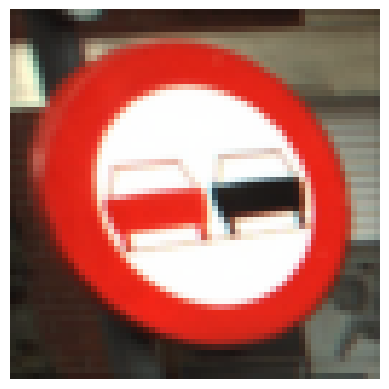

Label: 32


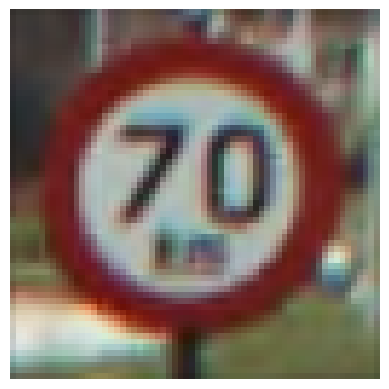

Label: 34


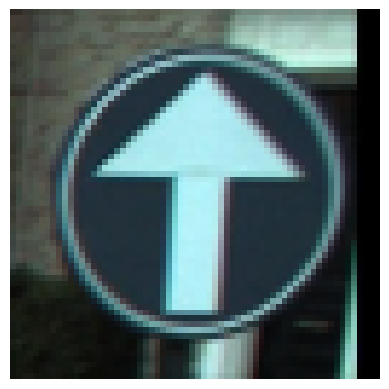

Label: 35


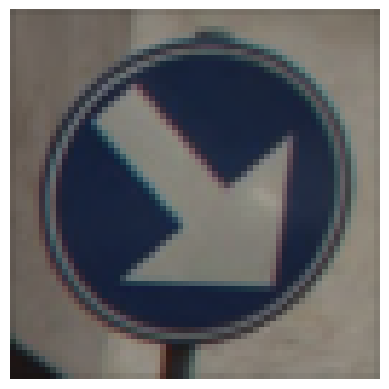

Label: 37


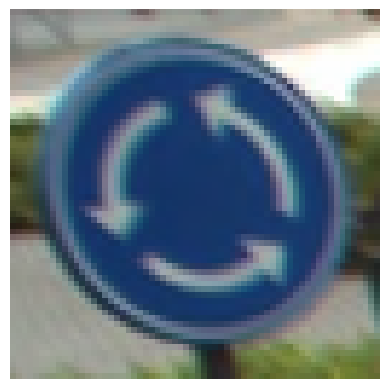

Label: 38


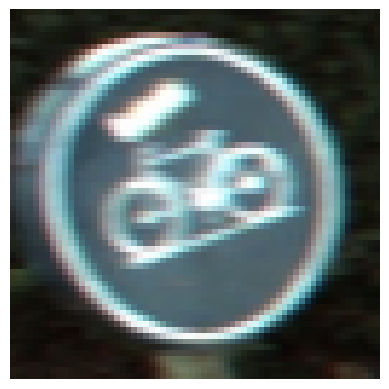

Label: 39


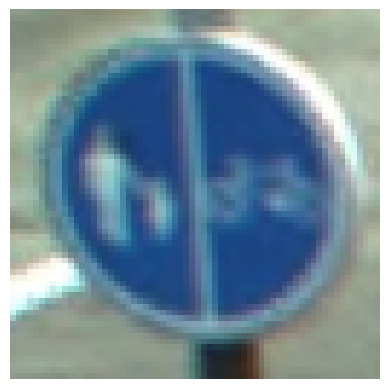

Label: 40


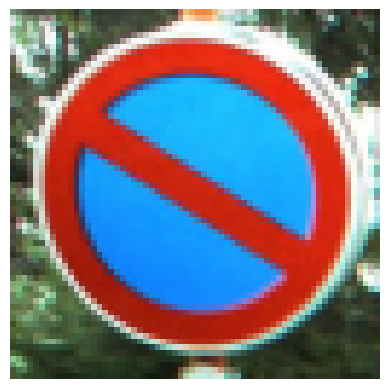

Label: 41


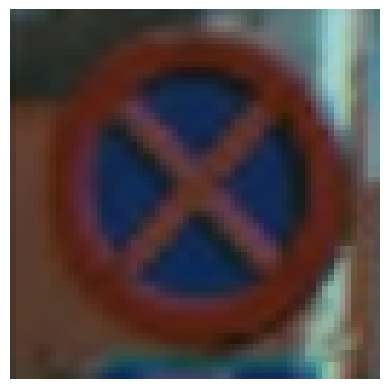

Label: 42


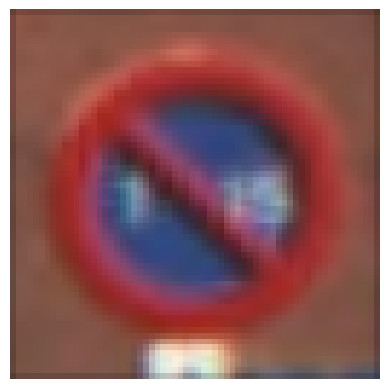

Label: 43


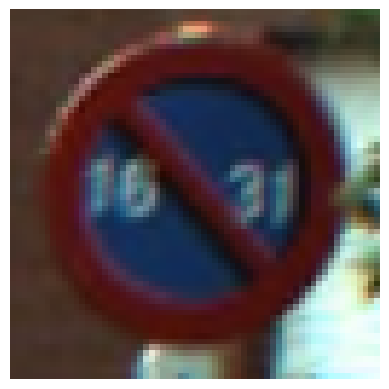

Label: 44


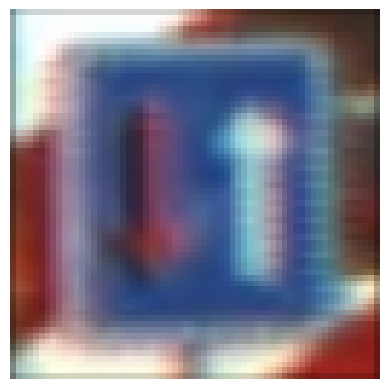

Label: 45


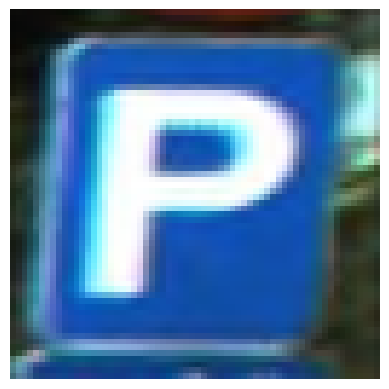

Label: 46


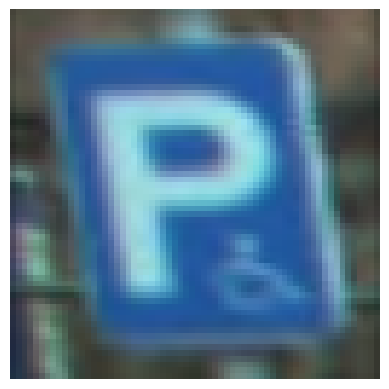

Label: 47


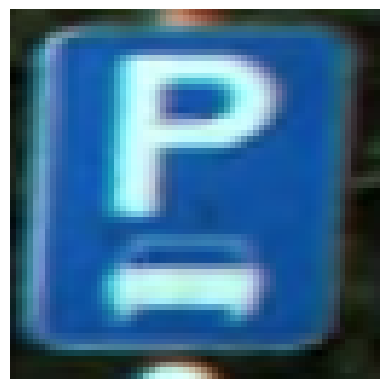

Label: 49


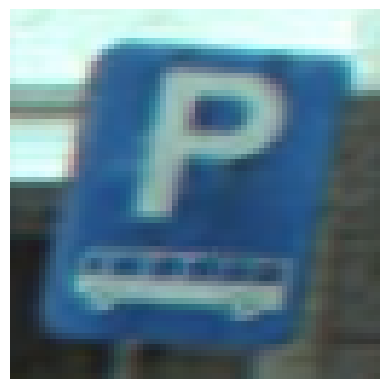

Label: 51


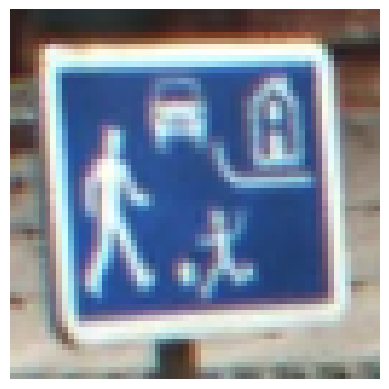

Label: 53


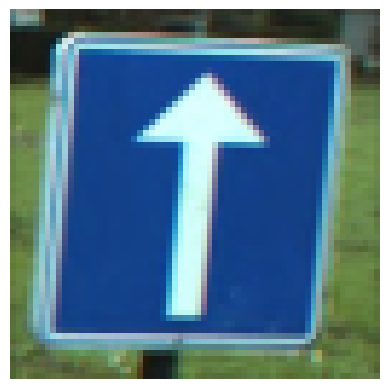

Label: 54


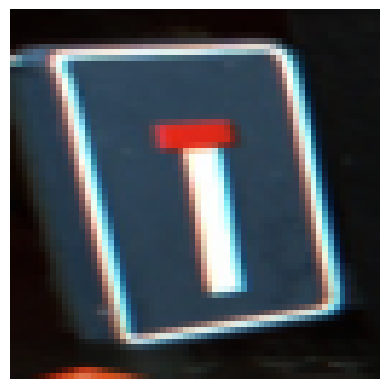

Label: 55


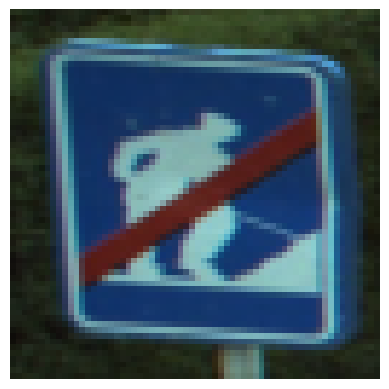

Label: 56


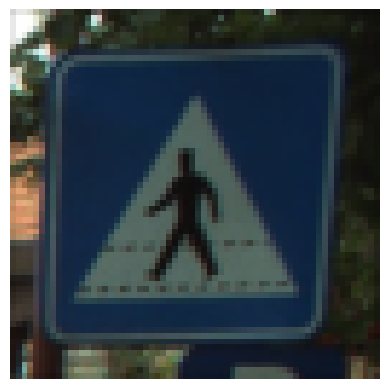

Label: 57


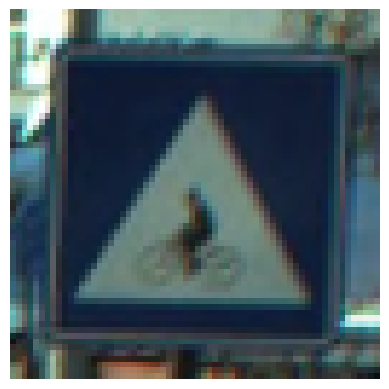

Label: 58


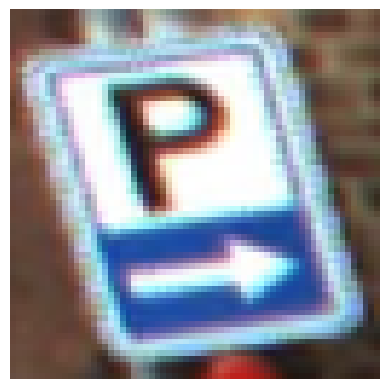

Label: 59


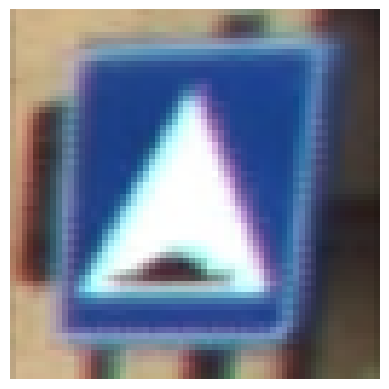

Label: 60


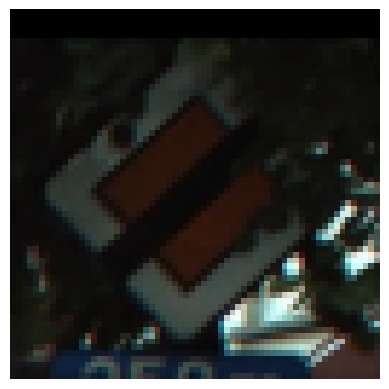

Label: 61


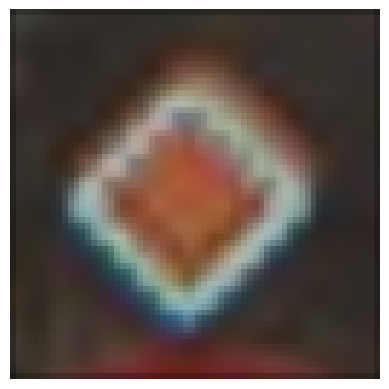

AttributeError: 'list' object has no attribute 'shape'

In [47]:
# Load the test dataset.
test_images, test_labels = load_data(test_data_dir)
# Transform the images, just like we did with the training set.
test_images64 = [skimage.transform.resize(image, (64, 64), mode='constant')
                 for image in test_images]
display_images_and_labels(test_images64, test_labels)


In [50]:
print(len(test_images))
print(len(test_labels))

2520
2520


In [51]:
from sklearn.metrics import classification_report

# prediction
# predict = model.predict(np.expand_dims(img, axis=0))
predict = model.predict(x_test)
pred= np.argmax(predict,axis=1)
# predicted_label = np.array([np.argmax(predict)])
# Generate the classification report
report = classification_report(y_test, pred)
# Print the classification report
print(report)

29/29 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.88      1.00      0.94        22
           2       0.40      0.67      0.50         3
           3       0.33      0.33      0.33         3
           4       0.00      0.00      0.00         3
           5       0.00      0.00      0.00         2
           6       0.67      0.50      0.57         4
           7       0.97      0.94      0.95        31
           8       1.00      0.80      0.89         5
           9       1.00      0.75      0.86         4
          10       0.60      0.75      0.67         4
          11       0.00      0.00      0.00         1
          12       1.00      1.00      1.00         4
          13       1.00      0.94      0.97        18
          14       0.69      1.00      0.82         9
          15       0.00      0.00      0.00         2
          16       0.00     

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


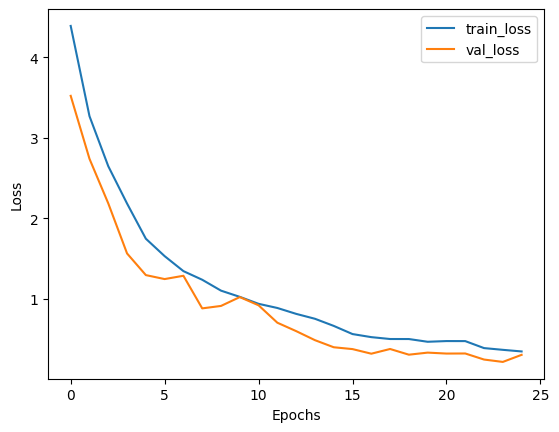

In [52]:
import matplotlib.pyplot as plt
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss)
plt.plot(val_loss)
plt.legend(['train_loss', 'val_loss'])

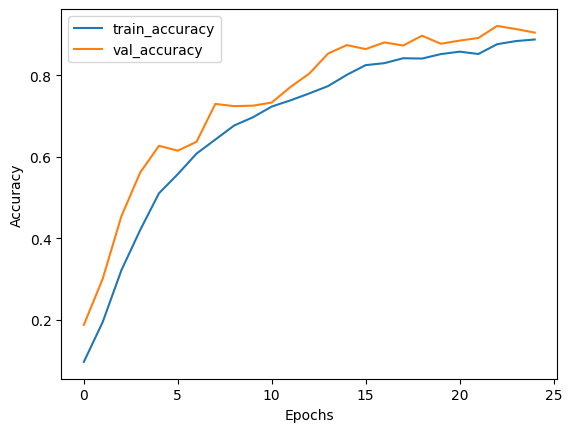

In [53]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train_accuracy', 'val_accuracy'])

### Using the Model to make predictions

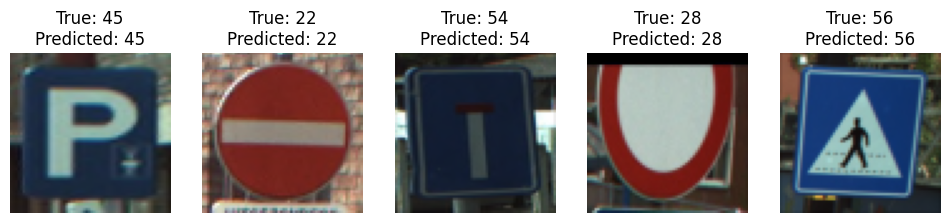

In [55]:
# We test the model with sample prediction
nums = 5
plt.figure(figsize=(12, 3))
for i in range(nums):
    # We consider a random sample
    radx = np.random.randint(0, len(x_test))
    img = x_test[radx]
    true_label = y_test[radx]

    predicted_label = pred[radx]

    # Plot the image and prediction
    plt.subplot(1, nums, i + 1)
    plt.imshow(img, cmap='binary')
    plt.title(f"True: {true_label}\nPredicted: {predicted_label}")
    plt.axis('off')

plt.show()


### Evaluation

Time to  test with validation dataset

In [56]:

score = model.evaluate(x_test, y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

29/29 [==============================] - 0s 8ms/step - loss: 0.3013 - accuracy: 0.9049
Test loss: 0.3012516498565674
Test accuracy: 0.9049180150032043


In [ ]:
# visualize using tensorboard

In [ ]:
models = pd.DataFrame({
    'Model' : ['CNN', 'VGG', 'Inception', 'Resnet50'],
    'Score' : [accuracy_score(y_test, y_pred_cnn), accuracy_score(y_test, y_pred_vgg), accuracy_score(y_test, y_pred_inc), accuracy_score(y_test, y_pred_resn)]})


models.sort_values(by = 'Score')